In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import *

In [3]:
df = pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


array([[<AxesSubplot:title={'center':'sales'}>]], dtype=object)

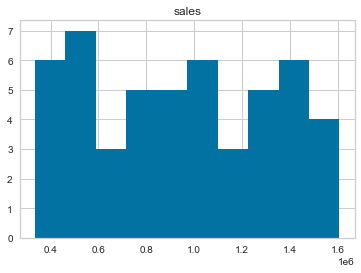

In [6]:
df.groupby('item')[['sales']].sum().hist()
#a histogram of each product's total quantity sold, telling us that some products are bought much more frequently than others

In [8]:
df['Order Month'] = pd.to_datetime(df['date'], dayfirst = True).dt.strftime('%Y-%m')

In [9]:
df['Month'] = [i.month for i in pd.to_datetime(df['date'], dayfirst = True)]
df['Year'] = [i.year for i in pd.to_datetime(df['date'], dayfirst = True)]
#create separate columns for order month and year
df.sample(5)

,date,store,item,sales,Order Month,Month,Year
856770,2014-01-12,10,47,20,2014-01,1,2014
396409,2013-06-17,8,22,89,2013-06,6,2013
716498,2014-12-08,3,40,20,2014-12,12,2014
276610,2015-06-04,2,16,49,2015-06,6,2015
328632,2017-11-14,10,18,115,2017-11,11,2017


In [10]:
#a popular method involved in inventory forecasting involves using a coefficient of variation, calculated by std dev divided by mean
#but CV will not be applicable to sporadically bought items
#so we need to identify the products where CV would be applicable
df.groupby('item')[['sales']].agg(['count', 'sum', 'mean', 'median', 'std']).sample(10)
#sorted by the products purchased the highest number of times

sales                                      
      count      sum       mean median        std
item                                             
29    18260  1271240  69.618839   67.0  23.635631
30    18260   736554  40.337021   39.0  14.363331
7     18260  1068777  58.531051   56.0  20.146002
48    18260   937703  51.352848   49.0  17.881917
36    18260  1406548  77.028916   74.0  26.067440
8     18260  1405108  76.950055   74.0  26.130697
15    18260  1607442  88.030778   85.0  29.522852
5     18260   335230  18.358708   18.0   7.265167
46    18260  1070764  58.639869   56.0  20.220879
42    18260   669925  36.688116   35.0  13.215112

In [11]:
# combine store and item column as time_series
df['store'] = ['store_' + str(i) for i in df['store']]
df['item'] = ['item_' + str(i) for i in df['item']]
df['time_series'] = df[['store', 'item']].apply(lambda x: '_'.join(x), axis=1)
df.drop(['store', 'item'], axis=1, inplace=True)
df.sample(5)

,date,sales,Order Month,Month,Year,time_series
465469,2017-07-24,30,2017-07,7,2017,store_5_item_26
343191,2017-09-26,55,2017-09,9,2017,store_8_item_19
116427,2016-10-21,76,2016-10,10,2016,store_4_item_7
43009,2015-10-09,41,2015-10,10,2015,store_4_item_3
141460,2015-05-09,131,2015-05,5,2015,store_8_item_8


array([[<AxesSubplot:title={'center':'sales'}>]], dtype=object)

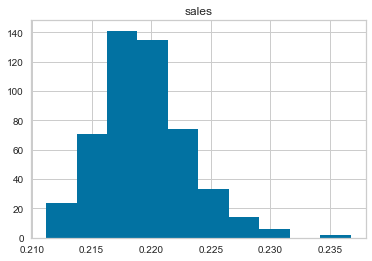

In [12]:
df_sum = df.groupby(['Year', 'Month', 'time_series'])[['sales']].sum().reset_index() 
pd.DataFrame(df_sum.groupby('time_series')['sales'].std() / df_sum[df_sum['sales'] > 0].groupby('time_series')['sales'].mean()).hist()
#this histogram plots the distribution of CV (coefficient of variation) for all store-item combinations, with the CV being quite low thus all combinations being quite forecastable
#this means we can proceed with forecasting each product's 3 month demand because we do not need to handle high CV products

In [13]:
#build sample algorithms with pycaret's regression module, stl and hp filter with statsmodels with a single product-store combination
data = df[df['time_series'] == 'store_1_item_30'].groupby(['Year', 'Month', 'time_series'])[['sales']].sum().reset_index()
data['Series'] = np.arange(1, len(data) + 1)
data['Date'] = pd.date_range(start = '2013-01-01', end = '2017-12-01', freq = 'MS')

In [14]:
df['date'].min() + pd.to_timedelta()

(60, 6)

In [15]:
train = data[data['Year'] < 2017]
test = data[data['Year'] >= 2017]
print(train.shape, test.shape)

(48, 6) (12, 6)


<Figure size 864x576 with 0 Axes>

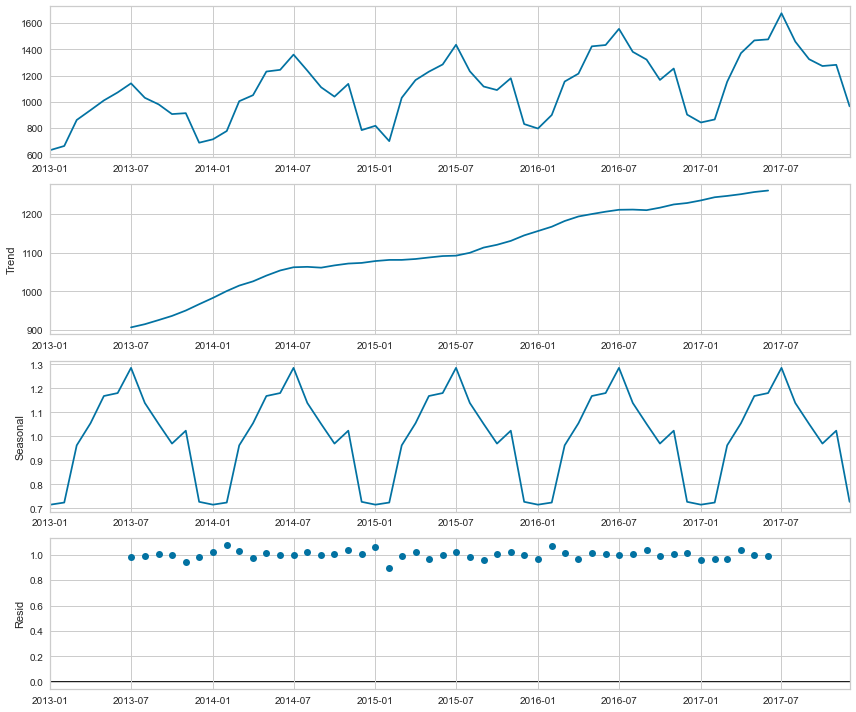

In [89]:
#plot a simple seasonal decomposition using statsmodels api
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(data[['Date', 'sales']].set_index('Date'), model = 'multiplicative')
plt.figure(figsize = (12, 8))
results.plot()
plt.show()

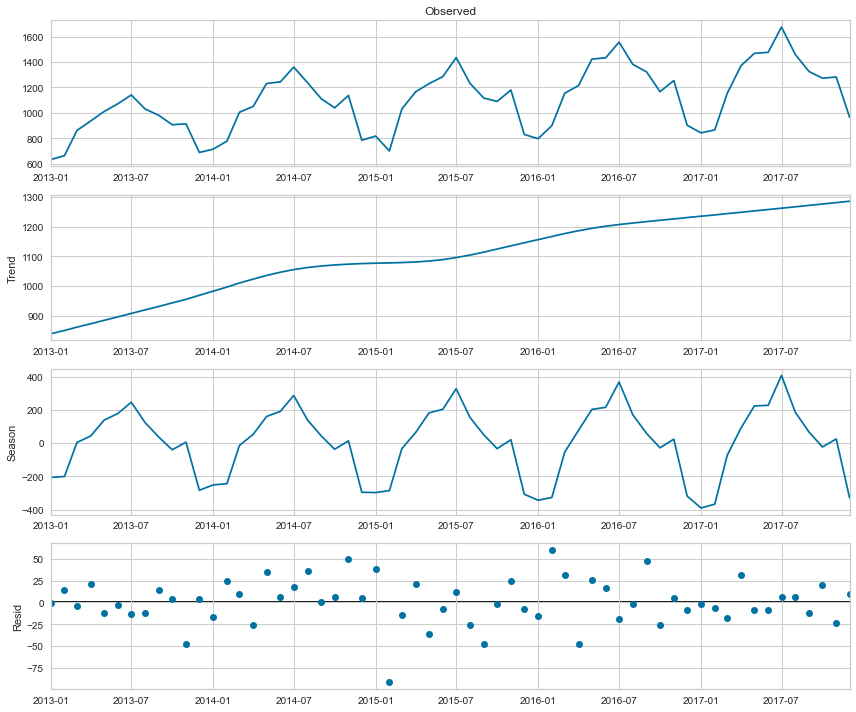

In [65]:
# STL - plot seasonal decomposition with Loess using statsmodels
#result is similar to above, clear seasonal and trend features
from statsmodels.tsa.seasonal import STL

res = STL(data[['Date', 'sales']].set_index('Date'), period = None, seasonal = 13).fit()
res.plot()
plt.show()

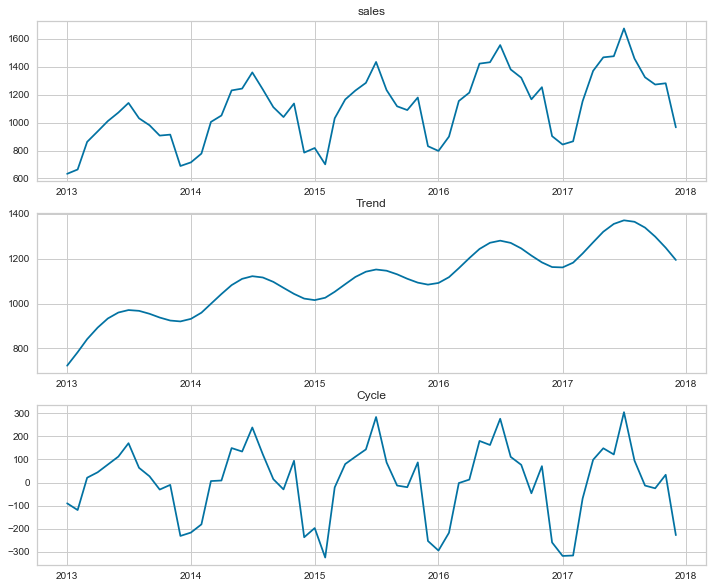

In [90]:
#using statsmodels hp_filter to visualize trend and cycles 
#using hodrick prescott filter shows the trend feature as a bit more seasonal
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.filters import hp_filter
from pylab import rcParams
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 10]

cycle, trend = hp_filter.hpfilter(data[['Date', 'sales']].set_index('Date'), 45)
fig, ax = plt.subplots(3, 1)
ax[0].plot(data[['Date', 'sales']].set_index('Date'))
ax[0].set_title('sales')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

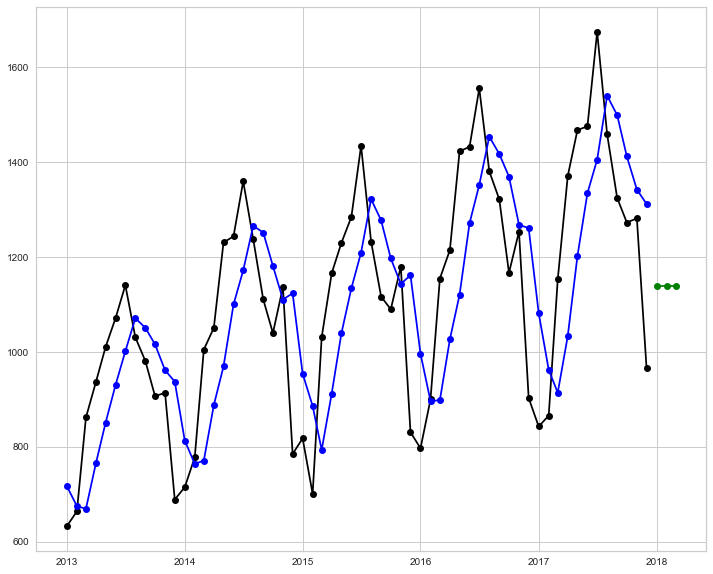

In [119]:
#fit exponential smoothing and holt smoothing models and use it to predict next 3 months forecast
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit1 = SimpleExpSmoothing(data[['Date', 'sales']].set_index('Date'), initialization_method = 'heuristic').fit(smoothing_level = 0.5, optimized = False)
fcast1 = fit1.forecast(3)

plt.plot(data[['Date', 'sales']].set_index('Date'), marker = 'o', color = 'black')
plt.plot(fit1.fittedvalues, marker = 'o', color = 'blue')
(line1,) = plt.plot(fcast1, marker = 'o', color = 'green')
plt.show()

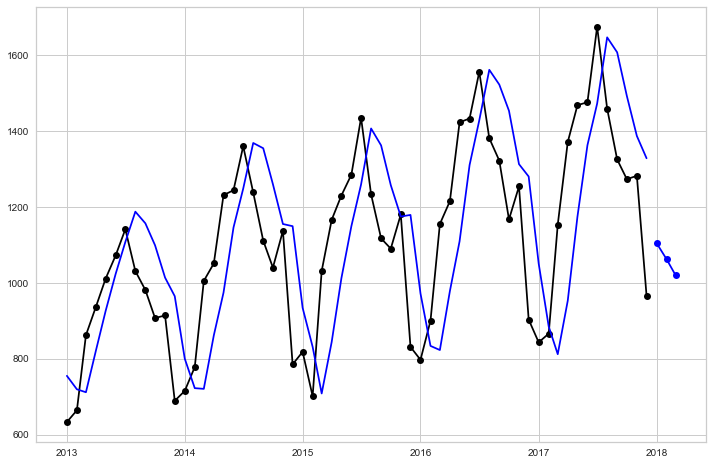

In [136]:
fit1 = Holt(data[['Date', 'sales']].set_index('Date'), initialization_method="estimated").fit(
    smoothing_level=0.5, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename("Holt's linear trend")
fit2 = Holt(data[['Date', 'sales']].set_index('Date'), exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.5, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(3).rename("Exponential trend")
fit3 = Holt(data[['Date', 'sales']].set_index('Date'), damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.5, smoothing_trend=0.2
)
fcast3 = fit3.forecast(3).rename("Additive damped trend")

#only plotting Holt's linear trend, excluding exponential trend for purposes of this demonstration
plt.figure(figsize=(12, 8))
plt.plot(data[['Date', 'sales']].set_index('Date'), marker="o", color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")


In [137]:
#next 3 months forecast using Holt's linear trend
fcast1

2018-01-01    1104.667870
2018-02-01    1062.210634
2018-03-01    1019.753399
Freq: MS, Name: Holt's linear trend, dtype: float64

In [ ]:
setup(data = train, target = 'sales', fold_strategy = 'timeseries', numeric_features = ['Year', 'Month', 'Series'], verbose = False, fold = 5, transform_target = True)
#setup pycaret regression module to forecast time series

In [120]:
#use compare_models function to show the best regressor model based on mean absolute error
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,111.4203,23587.9622,127.6846,-0.2469,0.1276,0.1181,0.0740
dt,Decision Tree Regressor,112.4000,22542.0000,129.2741,-0.1355,0.1224,0.1148,0.0540
xgboost,Extreme Gradient Boosting,123.5790,24799.0095,136.5784,-0.1646,0.1348,0.1274,0.2180
ada,AdaBoost Regressor,127.3153,25626.3070,145.5593,-0.1586,0.1446,0.1344,0.0900
et,Extra Trees Regressor,136.4057,29708.6642,152.3064,-0.3582,0.1534,0.1442,0.1280
catboost,CatBoost Regressor,136.7292,31934.6088,163.6618,-0.2698,0.1699,0.1514,1.0840
rf,Random Forest Regressor,138.7893,30617.1826,156.3491,-0.4203,0.1570,0.1480,0.1780
br,Bayesian Ridge,180.1649,51772.9996,218.9441,-0.3237,0.2176,0.1925,0.0540
huber,Huber Regressor,193.0294,59892.9615,233.7719,-0.6458,0.2306,0.2058,0.0640
lightgbm,Light Gradient Boosting Machine,203.1045,60302.5993,241.3308,-0.5147,0.2392,0.2175,0.0860


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,87.6861,22832.2052,151.1033,0.9238,0.0658,0.0383


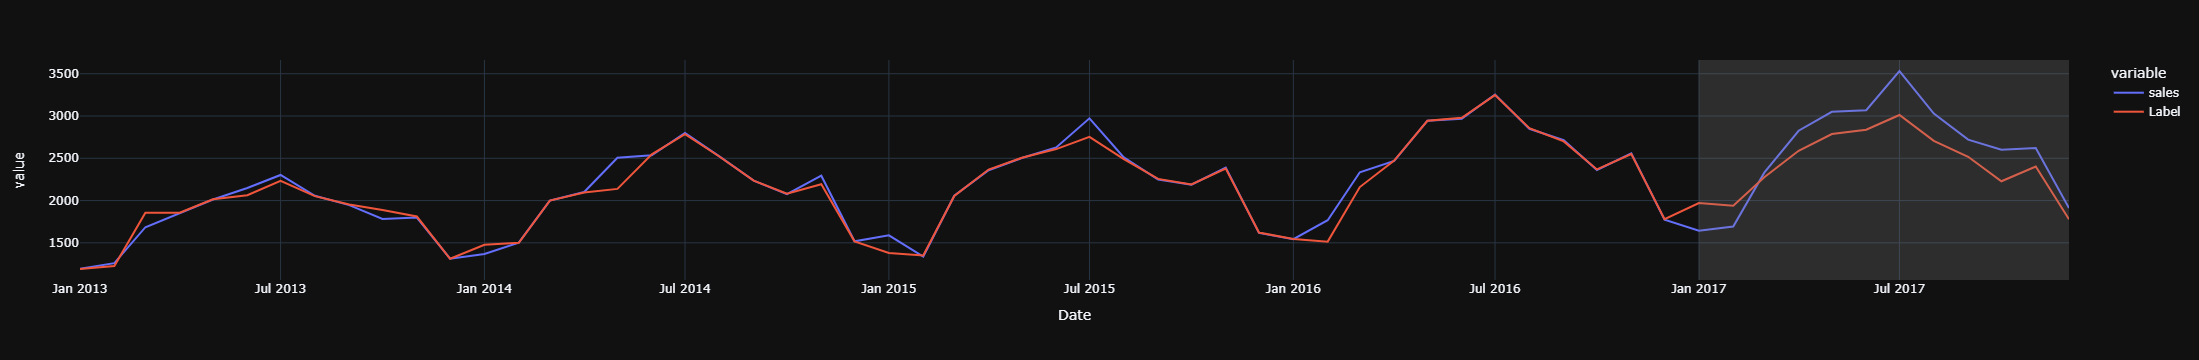

In [124]:
predictions = predict_model(best, data)

import plotly.express as px
# add a date column in the dataset
predictions['Date'] = pd.date_range(start='2013-01-01', end = '2017-12-01', freq = 'MS')
# line plot
fig = px.line(predictions, x='Date', y= ['sales', 'Label'], template = 'plotly_dark')
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2017-01-01", x1="2017-12-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show() 

In [143]:
#this is a very good fit, check for overfitting by comparing cross-validation scores with training scores
#since cross-validation training scores are much higher than validation metrics, this is a sign of overfitting and the model will not perform well on new data, this may also be due to limited training entries
tune_model(best, return_train_score = True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='log2',
                          min_impurity_decrease=0.01, min_samples_split=9,
                          n_estimators=120, random_state=5397, subsample=0.8)

In [16]:
#see if model is better with pycaret3's time series module
from pycaret.time_series import *

s1 = setup(data[['Date', 'sales']].set_index('Date'), target = 'sales', fold = 5)

,Description,Value
0,session_id,5567
1,Target,sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(60, 1)"
5,Transformed data shape,"(60, 1)"
6,Transformed train set shape,"(59, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [17]:
best = compare_models(verbose = False, sort = 'MAPE')

In [18]:
pull().head()
#this returns the models that were trained, with passive aggressive decision tree being the best in terms of mean absolute percentage error (MAPE)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
exp_smooth,Exponential Smoothing,0.3185,0.2656,31.4811,31.4811,0.0227,0.0227,0.098
ets,ETS,0.3201,0.2669,31.6307,31.6307,0.0229,0.0228,0.102
auto_arima,Auto ARIMA,0.3505,0.2924,34.6697,34.6697,0.0248,0.0245,1.682
theta,Theta Forecaster,0.3501,0.292,34.646,34.646,0.0248,0.0248,0.024
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize...,0.4001,0.3341,39.6246,39.6246,0.0287,0.0283,0.042


In [19]:
es = create_model('exp_smooth', fold = 10)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2017-01,0.4128,0.3510,43.7132,43.7132,0.0505,0.0492
1,2017-02,0.3905,0.3301,40.6167,40.6167,0.0352,0.0346
2,2017-03,1.0288,0.8589,104.3074,104.3074,0.0761,0.0791
3,2017-04,0.0673,0.0565,6.9143,6.9143,0.0047,0.0047
4,2017-05,0.2504,0.2095,25.3709,25.3709,0.0172,0.0170
5,2017-06,0.4536,0.3783,45.3382,45.3382,0.0271,0.0274
6,2017-07,0.0265,0.0222,2.6646,2.6646,0.0018,0.0018
7,2017-08,0.2702,0.2267,26.9866,26.9866,0.0204,0.0202
8,2017-09,0.2954,0.2452,28.8701,28.8701,0.0227,0.0229
9,2017-10,0.5469,0.4558,53.5462,53.5462,0.0418,0.0409


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
plot_model(es, plot = 'insample', fig_kwargs={'renderer': 'colab'})
#there is evidence of overfitting

In [185]:
#applying exponential smoothing model to a different product will tell us its performance on new data

In [21]:
#creates a dataframe from monthly sales for item 50 from store 3
test = df[df['time_series'] == 'store_3_item_50'].groupby(['Year', 'Month', 'time_series'])[['sales']].sum().reset_index()
test['Date'] = pd.date_range(start = '2013-01-01', end = '2017-12-01', freq = 'MS')

s2 = TSForecastingExperiment()
s2.setup(test[['Date', 'sales']][test['Date'] < '2017-01-01'].set_index('Date'), target = 'sales', fold = 5)

,Description,Value
0,session_id,8956
1,Target,sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(48, 1)"
5,Transformed data shape,"(48, 1)"
6,Transformed train set shape,"(47, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [22]:
es2 = s2.create_model('exp_smooth')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2016-06,0.2774,0.2396,53.5604,53.5604,0.0168,0.0167
1,2016-07,0.2009,0.1743,38.8274,38.8274,0.0136,0.0137
2,2016-08,0.6071,0.5283,117.0373,117.0373,0.0442,0.0452
3,2016-09,0.0545,0.0476,10.6921,10.6921,0.0043,0.0043
4,2016-10,0.2264,0.1985,44.4410,44.4410,0.0174,0.0172
Mean,nan,0.2733,0.2376,52.9116,52.9116,0.0192,0.0194
SD,nan,0.1826,0.1588,35.1145,35.1145,0.0133,0.0137


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [42]:
s2.plot_model(es2, plot =  'forecast', fig_kwargs={'renderer': 'colab'})

In [31]:
#uses ES model to predict sales and measure preformance for the next 12 months
yhat2 = s2.predict_model(es2, fh = 12)
yhat2 = yhat2.reset_index()
yhat2['index'] = yhat2['index'].astype(str)

In [55]:
s2.predict_model(es2, fh = 12).reset_index()

,index,y_pred
0,2016-12,1885.2037
1,2017-01,1865.3879
2,2017-02,1894.8826
3,2017-03,2479.7591
4,2017-04,2779.1029
5,2017-05,3021.3831
6,2017-06,3141.6421
7,2017-07,3482.2760
8,2017-08,3082.4891
9,2017-09,2774.4291


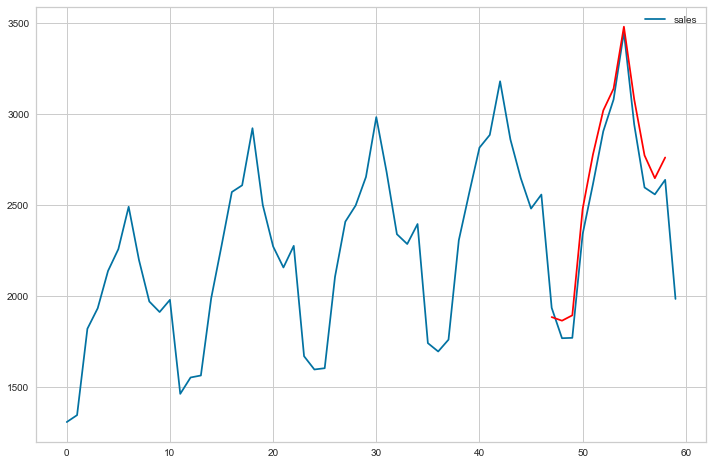

In [38]:
test['Order Month'] = test['Date'].dt.strftime('%Y-%m')
#plotting exponential smoothing model and calculating performance metrics
dft = test[['Order Month', 'sales']].join(yhat2.set_index('index'), on = 'Order Month', how = 'left')

dft[['Order Month', 'sales']].plot(kind = 'line', figsize = (12, 8))
plt.plot(dft['y_pred'], color = 'red')

In [39]:
from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error, mean_squared_error

r2 = r2_score(dft[~dft['y_pred'].isnull()]['sales'], dft[~dft['y_pred'].isnull()]['y_pred'])
mae = mean_absolute_error(dft[~dft['y_pred'].isnull()]['y_pred'], dft[~dft['y_pred'].isnull()]['sales'])
mse = mean_squared_error(dft[~dft['y_pred'].isnull()]['y_pred'], dft[~dft['y_pred'].isnull()]['sales'], squared=True)
rmse = ((dft[~dft['y_pred'].isnull()]['y_pred'] - dft[~dft['y_pred'].isnull()]['sales']) ** 2).mean() ** .5
print('R2 score is: ', r2, '\nMAE: is', mae, '\nMSE is: ', mse, '\nRMSE is: ', rmse)

R2 score is:  0.9459172418550259 
MAE: is 108.66986666666664 
MSE is:  13663.24567751833 
RMSE is:  116.88988697709622


In [40]:
#after build a second exponential smoothing algorithm and applying it to a new product, exponential smoothing seems to be the best predictor

In [41]:
s2.save_model(es2, model_name = 'exponential_smoothing06072022')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ExponentialSmoothing(seasonal='mul',
                                                                                      sp=12,
                                                                                      trend='add'))]))]),
 'exponential_smoothing06072022.pkl')

In [49]:
s2.save_config('es_config')

In [64]:
pd.date_range(start = '2017-12-01', end = '2018-12-01', freq = 'MS')

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [70]:
yhat2['Date'] = yhat2['index']

In [67]:
data.head()

,Year,Month,time_series,sales,Series,Date
0,2013,1,store_1_item_30,633,1,2013-01-01
1,2013,2,store_1_item_30,664,2,2013-02-01
2,2013,3,store_1_item_30,862,3,2013-03-01
3,2013,4,store_1_item_30,937,4,2013-04-01
4,2013,5,store_1_item_30,1011,5,2013-05-01


In [72]:
pd.concat((data, yhat2), axis = 0)

,Year,Month,time_series,sales,Series,Date,index,y_pred
0,2013.0,1.0,store_1_item_30,633.0,1.0,2013-01-01 00:00:00,NaN,NaN
1,2013.0,2.0,store_1_item_30,664.0,2.0,2013-02-01 00:00:00,NaN,NaN
2,2013.0,3.0,store_1_item_30,862.0,3.0,2013-03-01 00:00:00,NaN,NaN
3,2013.0,4.0,store_1_item_30,937.0,4.0,2013-04-01 00:00:00,NaN,NaN
4,2013.0,5.0,store_1_item_30,1011.0,5.0,2013-05-01 00:00:00,NaN,NaN
...,...,...,...,...,...,...,...,...
7,NaN,NaN,NaN,NaN,NaN,2017-07,2017-07,3482.2760
8,NaN,NaN,NaN,NaN,NaN,2017-08,2017-08,3082.4891
9,NaN,NaN,NaN,NaN,NaN,2017-09,2017-09,2774.4291
10,NaN,NaN,NaN,NaN,NaN,2017-10,2017-10,2649.0333
